#  ANSWERING BUSINESS QUESTIONS USING SQL
In this guided project, we're going to practice using our SQL skills to answer business questions.We'll be using the Chinook database that is provided as a SQLite database file called **chinook.db**. The <a href="https://s3.amazonaws.com/dq-content/602/2.1-m602.svg">Schema Diagram</a> looks like this. 

It's worth remembering that our database retains **'state'**, so if we run a query with a **CREATE** or **DROP** twice, the query will fail. We should have the skills to get ourselves untangled from these situations, but if you have trouble, or if you manage to lock your database, we have provided a *chinook-unmodified.db* file that you can copy over the *chinook.db* to restore it back to its initial state. To do this run **!cp chinook-unmodified.db chinook.db** in its own cell.

In [28]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3

In [29]:
#  create a run_query() function that takes a SQL query as an argument and
# returns a pandas dataframe of that query
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query,conn)

In [30]:
# function that takes a SQL command as an argument and 
#  executes it with the sqlite3 module
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

In [31]:
# create a show_tables() function that calls the run_query() function
# returns a list of all tables and views in the database
def show_tables():
    myquery = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(myquery)

In [32]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# ** 1. SELECTING ALBUMS TO PURCHASE **

The Chinook record store has just signed a deal with a new record label, and we need to select the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now. The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [33]:
q = '''
WITH usa_sales AS (
    SELECT 
        i.invoice_id AS invoice_id,
        il.track_id as track_id
    FROM invoice i
    INNER JOIN invoice_line il ON il.invoice_line_id = i.invoice_id
    WHERE i.billing_country = 'USA'
    ),
    usa_tracks_genres AS (
    SELECT
        usa_sales.invoice_id AS invoice_id,
        usa_sales.track_id AS track_id, 
        g.name AS genre
    FROM usa_sales 
    LEFT JOIN track t ON t.track_id = usa_sales.track_id
    LEFT JOIN genre g ON g.genre_id = t.genre_id),
    genre_totals AS (
    SELECT
        utg.genre as Genre, 
        COUNT(utg.track_id) AS Tracks_sold_total
    FROM usa_tracks_genres AS utg
    GROUP BY 1
        )

SELECT 
    gt.Genre AS Genre,
    gt.Tracks_sold_total AS Tracks_sold_total,
    CAST((CAST(gt.Tracks_sold_total as float) / (SELECT SUM(Tracks_sold_total)
                              FROM genre_totals)) * 100 as float) as Tracks_sold_percentage
FROM genre_totals AS gt
ORDER BY 3 DESC
'''
run_query(q)

,Genre,Tracks_sold_total,Tracks_sold_percentage
0,Rock,88,67.175573
1,Alternative & Punk,10,7.633588
2,Metal,8,6.106870
3,R&B/Soul,6,4.580153
4,Classical,4,3.053435
5,Jazz,3,2.290076
6,Alternative,2,1.526718
7,Electronica/Dance,2,1.526718
8,Latin,2,1.526718
9,Pop,2,1.526718


In [34]:
genre_sales_usa = run_query(q)

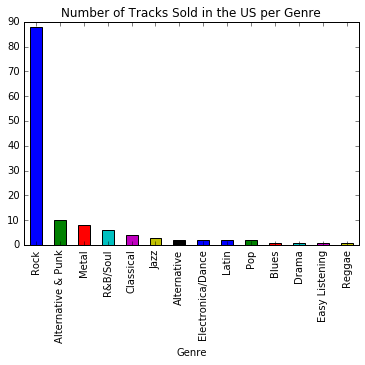

In [35]:
genre_sales_usa = genre_sales_usa.set_index('Genre')
plt.figure()
genre_sales_usa['Tracks_sold_total'].plot.bar()
plt.title('Number of Tracks Sold in the US per Genre')
plt.show()

From our analysis, the top three most selling albums are Rock, Alternative & Punk and Metal. So, the first three albums that will be added to the store are by: Red Tone, Slim Jim Bites and Meteor and the girls.

# ** 2. ANALYZING EMPLOYEE SALES PERFORMANCE **

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Our goal is to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

In [36]:
sales_query = '''
WITH sq_employee AS
(
SELECT
c.support_rep_id Employee_ID,
SUM(i.total) Total
FROM customer c 
INNER JOIN invoice i 
ON c.customer_id = i.customer_id
GROUP BY 1
)

SELECT sq.Employee_ID ID,
sq.Total Total, 
e.first_name||" "||e.last_name Employee,
e.title Title,
e.reports_to Reports_To,
e.birthdate AS Birthdate,
e.hire_date AS Hire_date,
e.country Country
FROM sq_employee sq 
INNER JOIN employee e 
ON e.employee_id = sq.Employee_ID
GROUP BY 2
'''
 
run_query(sales_query)

,ID,Total,Employee,Title,Reports_To,Birthdate,Hire_date,Country
0,5,1393.92,Steve Johnson,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,Canada
1,4,1584.00,Margaret Park,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,Canada
2,3,1731.51,Jane Peacock,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,Canada


In [37]:
sales_performance = run_query(sales_query)

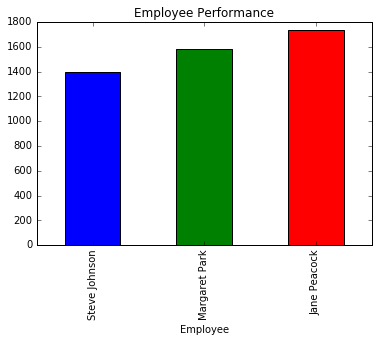

In [38]:
sales_performance = sales_performance.set_index('Employee')
plt.figure()
sales_performance['Total'].plot.bar()
plt.title('Employee Performance')
plt.show()

From our analysis, we can see that the sales agents are performing almost similar to each other with Jane Peacock being the youngest, on the lead. The sales agents were hired almost at the same time.

# **3. ANALYZING SALES BY COUNTRY **

Our next task is to analyze the sales data for customers from each different country using the country value from the customers table and not from the billing address in the invoice table.

In particular, you have been directed to calculate data, for each country, on the:

1. Total number of customers.
2. Total value of sales.
3. Average value of sales per customer.
4. Average order value.

In [39]:
c = '''
DROP VIEW IF EXISTS country_sales;
'''
run_command(c)

In [40]:
c = '''
CREATE VIEW country_sales AS
    SELECT 
        c.country AS Country,
        SUM(i.total) AS Total_Purchases,
        COUNT(DISTINCT(c.customer_id)) AS Total_Customers,
        COUNT(i.invoice_id) AS Total_Orders
    FROM invoice i
    INNER JOIN customer c ON c.customer_id = i.customer_id
    GROUP BY 1    
'''
run_command(c)

In [41]:
q = "SELECT * FROM country_sales ORDER BY 2 DESC"
run_query(q)

,Country,Total_Purchases,Total_Customers,Total_Orders
0,USA,1040.49,13,131
1,Canada,535.59,8,76
2,Brazil,427.68,5,61
3,France,389.07,5,50
4,Germany,334.62,4,41
5,Czech Republic,273.24,2,30
6,United Kingdom,245.52,3,28
7,Portugal,185.13,2,29
8,India,183.15,2,21
9,Ireland,114.84,1,13


In [42]:
q = '''
WITH country_sales_other AS (
        SELECT
            CASE
                WHEN Total_Customers = 1 THEN 'Other'
                ELSE Country
            END AS country_identification,
            Total_Purchases,
            Total_Customers,
            Total_Orders
        FROM country_sales),
    country_sales_agg AS (
        SELECT
            country_identification,
            SUM(Total_purchases) AS Total_Sales,
            SUM(Total_customers) AS Total_Customers,
            SUM(Total_Orders) AS Total_Orders
        FROM country_sales_other
        GROUP BY 1), 
    country_variables AS (
        SELECT
            country_identification as Country,
            Total_Customers,
            Total_Sales, 
            CAST(Total_Sales / Total_Customers as float) AS Average_sales_per_customer, 
            CAST(Total_Sales / Total_Orders as float) AS Average_order_value
        FROM country_sales_agg
            )

SELECT
    Country,
    Total_Sales,
    Average_sales_per_customer,
    Average_order_value
FROM (
      SELECT 
          cv.*,
          CASE
              WHEN cv.Country = 'Other' THEN 1
              ELSE 0
          END AS sort
      FROM country_variables cv
      )
ORDER BY sort ASC
'''
run_query(q)


,Country,Total_Sales,Average_sales_per_customer,Average_order_value
0,Brazil,427.68,85.536000,7.011148
1,Canada,535.59,66.948750,7.047237
2,Czech Republic,273.24,136.620000,9.108000
3,France,389.07,77.814000,7.781400
4,Germany,334.62,83.655000,8.161463
5,India,183.15,91.575000,8.721429
6,Portugal,185.13,92.565000,6.383793
7,USA,1040.49,80.037692,7.942672
8,United Kingdom,245.52,81.840000,8.768571
9,Other,1094.94,72.996000,7.448571


In [43]:
c = '''
DROP VIEW IF EXISTS country_sales_data;
'''
run_command(c)

In [44]:
c = '''
CREATE VIEW country_sales_data AS
     WITH country_sales_other AS (
            SELECT
                CASE
                    WHEN Total_Customers = 1 THEN 'Other'
                    ELSE Country
                END AS country_identification,
                Total_Purchases,
                Total_Customers,
                Total_Orders
            FROM country_sales),
        country_sales_agg AS (
            SELECT
                country_identification,
                SUM(Total_purchases) AS Total_Sales,
                SUM(Total_customers) AS Total_Customers,
                SUM(Total_Orders) AS Total_Orders
            FROM country_sales_other
            GROUP BY 1), 
        country_variables AS (
            SELECT
                country_identification as Country,
                Total_Customers,
                Total_Sales, 
                CAST(Total_Sales / Total_Customers as float) AS Average_sales_per_customer, 
                CAST(Total_Sales / Total_Orders as float) AS Average_order_value
            FROM country_sales_agg
                )

    SELECT
        Country,
        Total_Sales,
        Average_sales_per_customer,
        Average_order_value
    FROM (
          SELECT 
              cv.*,
              CASE
                  WHEN cv.Country = 'Other' THEN 1
                  ELSE 0
              END AS sort
          FROM country_variables cv
          )
    ORDER BY sort ASC  
'''
run_command(c)

In [45]:
q = '''
SELECT * FROM country_sales_data
'''
country_sales_data = run_query(q)

[]

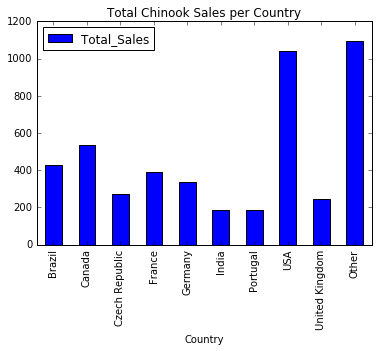

In [46]:
total_sales_country = country_sales_data.copy()
total_sales_country = total_sales_country[['Country', 'Total_Sales']]
total_sales_country = total_sales_country.set_index('Country')

plt.figure()
total_sales_country.plot.bar()
plt.title('Total Chinook Sales per Country')
plt.plot()

[]

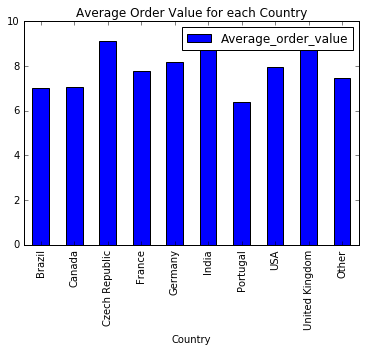

In [47]:
average_order_value_country = country_sales_data.copy()
average_order_value_country = average_order_value_country[['Country', 'Average_order_value']]
average_order_value_country = average_order_value_country.set_index('Country')

plt.figure()
average_order_value_country.plot.bar()
plt.title('Average Order Value for each Country')
plt.plot()

[]

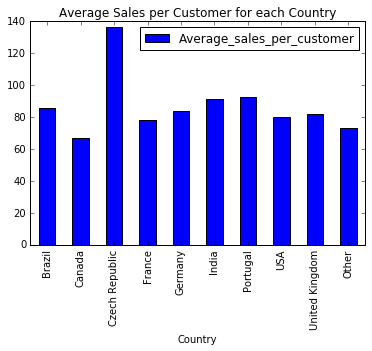

In [48]:
average_sales_country_customer = country_sales_data.copy()
average_sales_country_customer = average_sales_country_customer[['Country', 'Average_sales_per_customer']]
average_sales_country_customer = average_sales_country_customer.set_index('Country')

plt.figure()
average_sales_country_customer.plot.bar()
plt.title('Average Sales per Customer for each Country')
plt.plot()

According to our findings,USA is Chinook's largest market, followed by Canada and Brazil. The 'Other' row includes sales from countries with a single customer. However, we see a clear difference between average sales in all of its countries (around 80 - 90 USD per customer on average) and average sales in Czech Republic of 136 USD per customer. This indicates that in this country average revenue per customer is significantly higher and targeted marketing could potentially be more profitable per customer compared to its other markets. Average order value tends to be approximately 8 USD per order; again, we notice that in the Czech Republic this value is slightly higher than in other countries at 9 USD per order.

# ** 4. ALBUM VS INDIVIDUAL TRACKS**

The Chinook store is setup in a way that allows customers to make purchases in one of the two ways:

1. Purchase a whole album
2. Purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management is currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [49]:
# View with album ID and track ID from the tracks included in that album.
c = '''
DROP VIEW IF EXISTS album_tracks_dictionary
'''
run_command(c)

In [50]:
c = '''
CREATE VIEW album_tracks_dictionary AS
    SELECT 
        a.album_id AS album_id,
        t.track_id AS track_id
    FROM album a
    INNER JOIN track t ON a.album_id = t.album_id
'''
run_command(c)

In [51]:
q = '''
SELECT * FROM album_tracks_dictionary
'''
run_query(q)

,album_id,track_id
0,1,1
1,1,6
2,1,7
3,1,8
4,1,9
5,1,10
6,1,11
7,1,12
8,1,13
9,1,14


In [52]:
# Table of Chinook's sales including invoice ID, track ID and album ID.
c = '''
DROP VIEW IF EXISTS invoice_tracks_album
'''
run_command(c)

In [53]:
c = '''
CREATE VIEW invoice_tracks_album AS
    SELECT 
        il.invoice_id as invoice_id,
        at.album_id AS album_id,
        at.track_id AS track_id
    FROM invoice_line il
    INNER JOIN album_tracks_dictionary at ON at.track_id = il.track_id
'''
run_command(c)
q = '''
SELECT * FROM invoice_tracks_album
'''
run_query(q)

,invoice_id,album_id,track_id
0,1,91,1158
1,1,91,1159
2,1,91,1160
3,1,91,1161
4,1,91,1162
5,1,91,1163
6,1,91,1164
7,1,91,1165
8,1,91,1166
9,1,91,1167


In [54]:
q = '''
WITH invoice_full_dictionary AS
(
SELECT 
    ita.invoice_id AS invoice_id,
    CASE 
        WHEN
            (
            SELECT track_id FROM (SELECT itainv.track_id AS track_id
                                  FROM invoice_tracks_album itainv
                                  WHERE itainv.invoice_id = ita.invoice_id)
            EXCEPT 
            SELECT track_id FROM (SELECT ald.track_id AS track_id
                                  FROM album_tracks_dictionary ald
                                  WHERE ald.album_id = ita.album_id)
            ) IS NULL
            AND
            (
            SELECT track_id FROM (SELECT ald.track_id AS track_id
                                  FROM album_tracks_dictionary ald
                                  WHERE ald.album_id = ita.album_id)
            EXCEPT 
            SELECT track_id FROM (SELECT itainv.track_id AS track_id
                                  FROM invoice_tracks_album itainv
                                  WHERE itainv.invoice_id = ita.invoice_id)
            ) IS NULL
            THEN 1
        ELSE 0
    END AS Full_Album
FROM invoice_tracks_album ita
),
invoice_dictionary AS
(
SELECT 
    invoice_id,
    MAX(Full_Album) as Full_Album
FROM invoice_full_dictionary 
GROUP BY 1
)

SELECT
    COUNT(id.invoice_id) AS Total_invoices,
    SUM(id.Full_Album) AS Total_Full_Album,
    (CAST(SUM(id.Full_Album) / CAST(COUNT(id.invoice_id) as float) * 100 as float)) AS Percentage_Full_Album
FROM invoice_dictionary id
'''
run_query(q)

,Total_invoices,Total_Full_Album,Percentage_Full_Album
0,614,114,18.566775


From the above, we note that approximately 19% of invoices are related to the purchase of whole albums. From this, we can infer that approximately 81% of purchases are made by customers seeking specific tracks, instead of purchasing whole albums. This seems to indicate that Chinook's strategy of only purchasing popular tracks could be a profitable one as purchases do not appear to be driven by less popular songs that are part of albums.